In [23]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

In [24]:
import kagglehub
import os

np.random.seed(11232025)
dataset_path = kagglehub.dataset_download('bhavikjikadara/dog-and-cat-classification-dataset')
directory = os.path.join(dataset_path, 'PetImages')

In [25]:
images = []
labels = []

try:
  for foldr in os.listdir(directory):
    for filee in os.listdir(os.path.join(directory, foldr)):
      images.append(os.path.join(foldr, filee))
      labels.append(foldr)

except Exception as e:
  print(f'Error: {e}')

all_df = pd.DataFrame({
    'Images': images,
    'Labels': labels
    })

all_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24998 entries, 0 to 24997
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Images  24998 non-null  object
 1   Labels  24998 non-null  object
dtypes: object(2)
memory usage: 390.7+ KB


In [26]:
all_df.groupby("Labels").count()

,Images
Labels,
Cat,12499
Dog,12499


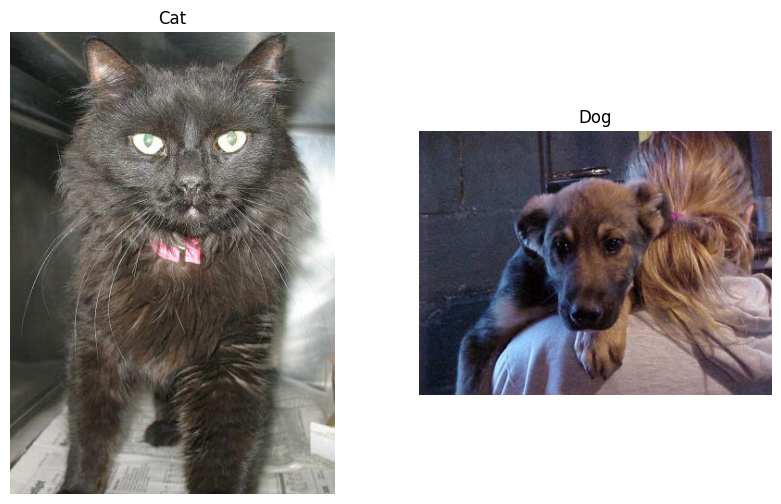

In [27]:
plt.figure(figsize=(10, 6))

for i, label in enumerate(all_df['Labels'].unique()):
    sample = all_df[all_df['Labels'] == label].sample(1).iloc[0]
    img_path = os.path.join(directory, sample['Images'])
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    plt.subplot(1, len(all_df['Labels'].unique()), i+1)
    plt.imshow(img)
    plt.title(label)
    plt.axis('off')

plt.show()

In [28]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_df, test_df = train_test_split(all_df, test_size=0.2, random_state=111620206, stratify=all_df['Labels'])

In [29]:
train_df_small = train_df.sample(n=100, random_state=42).reset_index(drop=True)

In [30]:
trainimgen = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True,
    shear_range=0.2
    )

train_data = trainimgen.flow_from_dataframe(
    dataframe=train_df,
    directory=directory,
    x_col='Images',
    y_col='Labels',
    target_size=(224,224),
    color_mode='rgb',
    class_mode='binary',
    batch_size=16,
)




Found 19998 validated image filenames belonging to 2 classes.


In [31]:
testimgen = ImageDataGenerator()

test_data = testimgen.flow_from_dataframe(
    dataframe=test_df,
    directory=directory,
    x_col='Images',
    y_col='Labels',
    target_size=(224,224),
    color_mode='rgb',
    class_mode='binary',
    batch_size=16,
    shuffle=False # ensures the prediction order matches the label order
)

Found 5000 validated image filenames belonging to 2 classes.


## Model Time

In [32]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        # Conv block 1
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Conv block 2
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Conv block 3
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # For 224x224 input: after 3 poolings -> 28x28
        self.fc1 = nn.Linear(28*28*64, 128)
        self.fc2 = nn.Linear(128, 2)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        
        x = F.relu(self.conv3(x))
        x = self.pool3(x)
        
        x = x.reshape(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [33]:
class ParameterTracker:
    def __init__(self, model, num_params_to_track=10):
        self.history = {
            'conv1_weight': [],
            'fc1_weight': [],
            'fc2_bias': [],
        }

        # Randomly select indices to track
        conv1_size = model.conv1.weight.numel()
        fc1_size = model.fc1.weight.numel()
        fc2_bias_size = model.fc2.bias.numel()

        self.indices = {
            'conv1': np.random.choice(conv1_size, num_params_to_track, replace=False),
            'fc1': np.random.choice(fc1_size, num_params_to_track, replace=False),
            'fc2_bias': np.random.choice(fc2_bias_size, min(num_params_to_track, fc2_bias_size), replace=False),
        }

    def record(self, model):
        # Conv1 weights
        weight = model.conv1.weight.detach().cpu().flatten().numpy()
        self.history['conv1_weight'].append(weight[self.indices['conv1']])

        # FC1 weights
        weight = model.fc1.weight.detach().cpu().flatten().numpy()
        self.history['fc1_weight'].append(weight[self.indices['fc1']])

        # FC2 biases
        bias = model.fc2.bias.detach().cpu().numpy()
        self.history['fc2_bias'].append(bias[self.indices['fc2_bias']])

    def plot_evolution(self):
        fig, axes = plt.subplots(3, 1, figsize=(15, 12))
        fig.suptitle('Parameter Evolution During Training', fontsize=16)

        epochs = np.arange(len(self.history['conv1_weight']))

        # Conv1 weights
        for i in range(len(self.indices['conv1'])):
            weight_values = [epoch_vals[i] for epoch_vals in self.history['conv1_weight']]
            axes[0].plot(epochs, weight_values, alpha=0.7, label=f'Weight {i}')
        axes[0].set_title('Conv1 Weight Evolution')
        axes[0].set_xlabel('Epoch')
        axes[0].set_ylabel('Weight value')
        axes[0].grid(alpha=0.3)

        # FC1 weights
        for i in range(len(self.indices['fc1'])):
            weight_values = [epoch_vals[i] for epoch_vals in self.history['fc1_weight']]
            axes[1].plot(epochs, weight_values, alpha=0.7)
        axes[1].set_title('FC1 Weight Evolution')
        axes[1].set_xlabel('Epoch')
        axes[1].set_ylabel('Weight value')
        axes[1].grid(alpha=0.3)

        # FC2 biases
        for i in range(len(self.indices['fc2_bias'])):
            bias_values = [epoch_vals[i] for epoch_vals in self.history['fc2_bias']]
            axes[2].plot(epochs, bias_values, alpha=0.7, marker='o', markersize=3)
        axes[2].set_title('FC2 Bias Evolution')
        axes[2].set_xlabel('Epoch')
        axes[2].set_ylabel('Bias value')
        axes[2].grid(alpha=0.3)

        plt.tight_layout()
        plt.show()

In [34]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

model = CNN().to(device)
model

Using device: cuda


CNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=50176, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=2, bias=True)
)

In [35]:
print(f"train_data will have {len(train_data)} batches")

train_data will have 1250 batches


In [36]:
save_dir = '../models/'

## Training

In [37]:
# criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
# tracker = ParameterTracker(model, num_params_to_track=10)
# tracker.record(model)

# num_epochs = 30
# num_batches = len(train_data)
# train_losses = []
# val_accuracies = []

# # Early stopping parameters
# best_val_accuracy = 0.0
# patience = 10
# patience_counter = 0
# best_model_state = None

# for epoch in range(num_epochs):
#     beta = max_beta * min(1.0, epoch / 10)
#     model.train()
#     total_loss = 0
    
#     for batch_idx, (data, target) in enumerate(train_data):
#         if batch_idx >= num_batches:
#             break
#         data = torch.FloatTensor(data).to(device)
#         target = torch.LongTensor(target.astype(int)).to(device)
        
#         # Normalize pixel values to [0, 1]
#         if data.max() > 1.0:
#             data = data / 255.0
        
#         # Transpose from (batch, height, width, channels) to (batch, channels, height, width)
#         data = data.permute(0, 3, 1, 2)
        
#         # Forward pass
#         output = model(data)
#         loss = criterion(output, target)
        
#         # Backward pass
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()
        
#         total_loss += loss.item()
    
#     avg_loss = total_loss / len(train_data)
#     train_losses.append(avg_loss)
#     tracker.record(model)
    
#     # ============ VALIDATION ACCURACY ============
#     # Calculate validation accuracy every epoch for early stopping
#     model.eval()
#     correct = 0
#     total = 0
#     with torch.no_grad():
#         for batch_idx, (data, target) in enumerate(test_data):
#             if batch_idx >= len(test_data):
#                 break
#             data = torch.FloatTensor(data).to(device)
#             target = torch.LongTensor(target.astype(int)).to(device)
#             if data.max() > 1.0:
#                 data = data / 255.0
#             data = data.permute(0, 3, 1, 2)
#             outputs = model(data)
#             _, predicted = torch.max(outputs.data, 1)
#             total += target.size(0)
#             correct += (predicted == target).sum().item()
    
#     val_accuracy = 100 * correct / total
#     val_accuracies.append(val_accuracy)
    
#     print(f'Epoch {epoch+1}/{num_epochs}:')
#     print(f'  Loss: {avg_loss:.4f}')
#     print(f'  Validation Accuracy: {val_accuracy:.2f}%')
    
#     # Early stopping logic
#     if val_accuracy > best_val_accuracy:
#         best_val_accuracy = val_accuracy
#         patience_counter = 0
#         # Save best model state
#         best_model_state = {
#             'epoch': epoch + 1,
#             'model_state_dict': model.state_dict().copy(),
#             'optimizer_state_dict': optimizer.state_dict(),
#             'train_losses': train_losses.copy(),
#             'val_accuracies': val_accuracies.copy(),
#             'tracker_history': tracker.history.copy(),
#             'tracker_indices': tracker.indices.copy(),
#             'best_val_accuracy': best_val_accuracy,
#         }
#         print(f'New best validation accuracy: {best_val_accuracy:.2f}%')
#     else:
#         patience_counter += 1
#         print(f'Patience: {patience_counter}/{patience}')
        
#         if patience_counter >= patience:
#             print(f'\nEarly stopping triggered after {epoch + 1} epochs!')
#             print(f'Best validation accuracy: {best_val_accuracy:.2f}%')
#             # Restore best model
#             model.load_state_dict(best_model_state['model_state_dict'])
#             break
    
#     # Save checkpoint every 5 epochs
#     if (epoch + 1) % 5 == 0:
#         torch.save({
#             'epoch': epoch + 1,
#             'model_state_dict': model.state_dict(),
#             'optimizer_state_dict': optimizer.state_dict(),
#             'train_losses': train_losses,
#             'val_accuracies': val_accuracies,
#             'tracker_history': tracker.history,
#             'tracker_indices': tracker.indices,
#         }, f'{save_dir}/checkpoint_epoch_{epoch+1}_standard.pth')
#         print(f"Checkpoint saved at epoch {epoch+1}")

# if best_model_state:
#     torch.save(best_model_state, f'{save_dir}/standard_cnn_catdog_best.pth')
#     print(f"\nBest model saved with validation accuracy: {best_val_accuracy:.2f}%")

# torch.save({
#     'epoch': epoch + 1,
#     'model_state_dict': model.state_dict(),
#     'optimizer_state_dict': optimizer.state_dict(),
#     'train_losses': train_losses,
#     'val_accuracies': val_accuracies,
#     'tracker_history': tracker.history,
#     'tracker_indices': tracker.indices,
# }, f'{save_dir}/standard_cnn_catdog_final.pth')

# print("Final model saved as 'standard_cnn_catdog_final.pth'")

In [38]:
# # Plot training loss and validation accuracy
# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# # Plot training loss
# ax1.plot(range(1, num_epochs + 1), train_losses, marker='o')
# ax1.set_xlabel('Epoch')
# ax1.set_ylabel('Training Loss')
# ax1.set_title('Training Loss over Epochs')
# ax1.grid(True)

# # Plot validation accuracy
# val_epochs = list(range(2, num_epochs + 1, 2))
# ax2.plot(val_epochs, val_accuracies, marker='o', color='green')
# ax2.set_xlabel('Epoch')
# ax2.set_ylabel('Validation Accuracy (%)')
# ax2.set_title('Validation Accuracy over Epochs')
# ax2.grid(True)

# plt.tight_layout()
# plt.show()

# print(f"\nFinal Training Loss: {train_losses[-1]:.4f}")
# print(f"Final Validation Accuracy: {val_accuracies[-1]:.2f}%")

## Analysis

In [39]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = CNN().to(device)
checkpoint = torch.load(f'{save_dir}/standard_cnn_catdog.pth', weights_only=False)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

CNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=50176, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=2, bias=True)
)

In [40]:
# ============ PREDICTIONS ============

# Prepare test data by converting from ImageDataGenerator to numpy arrays
print("Converting test data to numpy arrays...")
X_test = []
y_test = []

for batch_idx, (data, target) in enumerate(test_data):
    X_test.append(data)
    y_test.append(target)

    # Break after we've gone through all batches
    if batch_idx >= len(test_data) - 1:
        break

X_test = np.concatenate(X_test, axis=0)
y_test = np.concatenate(y_test, axis=0)

print(f"Test data shape: {X_test.shape}")
print(f"Test labels shape: {y_test.shape}")


Converting test data to numpy arrays...
Test data shape: (5000, 224, 224, 3)
Test labels shape: (5000,)


Predictions complete! Shape: (5000,)
Probabilities shape: (5000, 2)


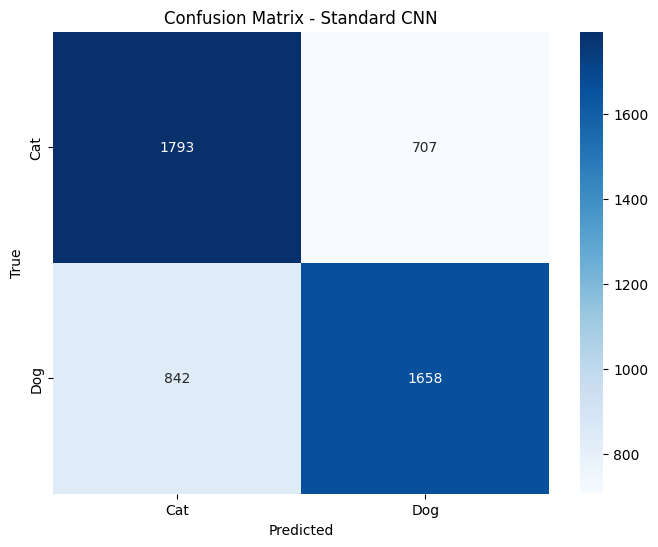

              precision    recall  f1-score   support

         Cat       0.68      0.72      0.70      2500
         Dog       0.70      0.66      0.68      2500

    accuracy                           0.69      5000
   macro avg       0.69      0.69      0.69      5000
weighted avg       0.69      0.69      0.69      5000



In [41]:
model.eval()
y_pred_list = []
y_pred_proba_list = []
batch_size = 32

with torch.no_grad():
    for i in range(0, len(X_test), batch_size):
        batch_end = min(i + batch_size, len(X_test))
        batch_data = X_test[i:batch_end]
        batch_tensor = torch.FloatTensor(batch_data).permute(0, 3, 1, 2).to(device)
        
        outputs = model(batch_tensor)
        probs = F.softmax(outputs, dim=1)  # Convert logits to probabilities
        _, batch_pred = torch.max(outputs, 1)
        
        # Move predictions and probabilities back to CPU and store
        y_pred_list.extend(batch_pred.cpu().numpy())
        y_pred_proba_list.extend(probs.cpu().numpy())
        
        # Clear GPU memory
        del batch_tensor, outputs, batch_pred, probs
        torch.cuda.empty_cache()
        
        # if (i // batch_size) % 10 == 0:
        #     print(f"-Processed {i}/{len(X_test)} images...")

y_pred = np.array(y_pred_list)
y_pred_proba = np.array(y_pred_proba_list)
y_test_true = y_test.astype(int)

print(f"Predictions complete! Shape: {y_pred.shape}")
print(f"Probabilities shape: {y_pred_proba.shape}")

cm = confusion_matrix(y_test_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Cat', 'Dog'],
            yticklabels=['Cat', 'Dog'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - Standard CNN')
plt.show()

print(classification_report(y_test_true, y_pred,
                          target_names=['Cat', 'Dog']))

Test Accuracy: 0.6902
Total misclassified: 1549


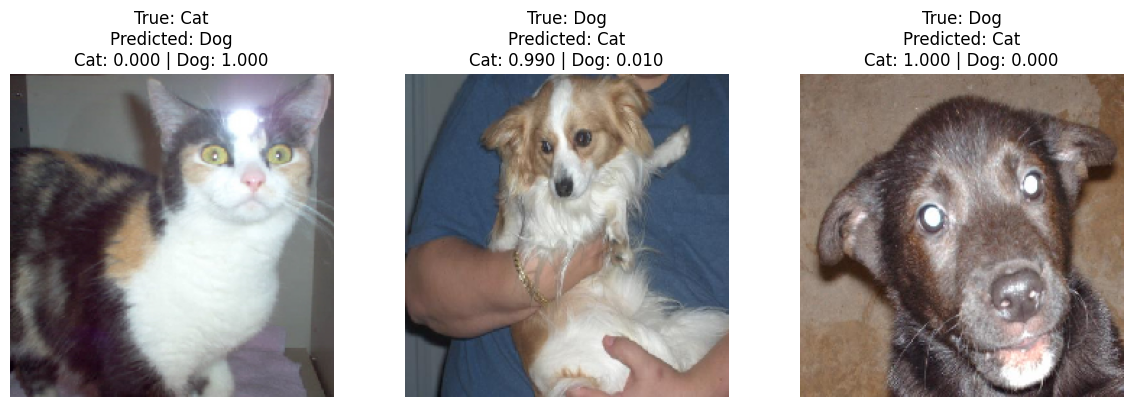

Total correct: 3451


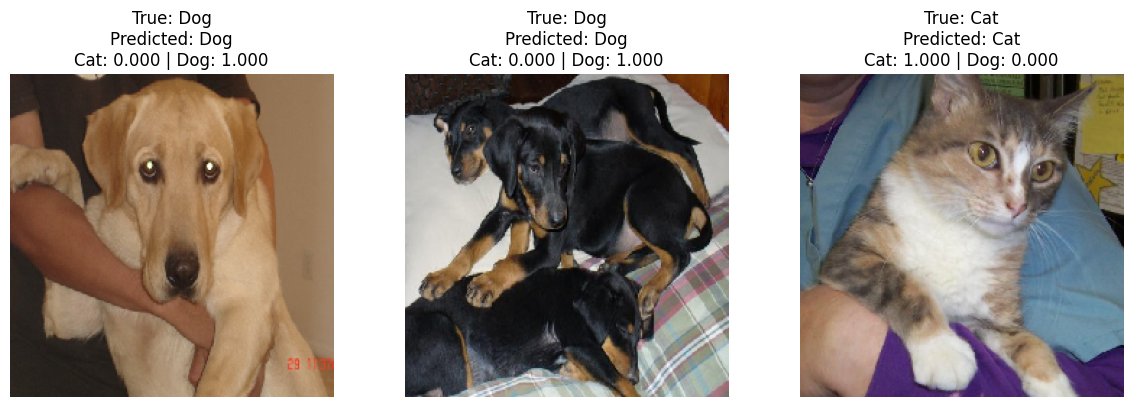

In [42]:
accuracy = (y_pred == y_test_true).mean()
print(f"Test Accuracy: {accuracy:.4f}")

# Misclassified examples
misclassified_idx = np.where(y_pred != y_test_true)[0]

print(f"Total misclassified: {len(misclassified_idx)}")
n_examples = min(3, len(misclassified_idx))
random_idx = np.random.choice(misclassified_idx, n_examples, replace=False)

fig, axes = plt.subplots(1, 3, figsize=(12, 4))
class_names = ['Cat', 'Dog']

for i, idx in enumerate(random_idx):
    img = X_test[idx].astype(np.uint8)
    cat_prob = y_pred_proba[idx][0]
    dog_prob = y_pred_proba[idx][1]
    
    axes[i].imshow(img)
    axes[i].set_title(f"True: {class_names[y_test_true[idx]]}\n"
                     f"Predicted: {class_names[y_pred[idx]]}\n"
                     f"Cat: {cat_prob:.3f} | Dog: {dog_prob:.3f}")
    axes[i].axis('off')

plt.tight_layout()
plt.show()

# Correct predictions
correct_idx = np.where(y_pred == y_test_true)[0]
print(f"Total correct: {len(correct_idx)}")

n_correct = min(3, len(correct_idx))
correct_random_idx = np.random.choice(correct_idx, n_correct, replace=False)

fig, axes = plt.subplots(1, 3, figsize=(12, 4))

for i, idx in enumerate(correct_random_idx):
    img = X_test[idx].astype(np.uint8)
    cat_prob = y_pred_proba[idx][0]
    dog_prob = y_pred_proba[idx][1]
    
    axes[i].imshow(img)
    axes[i].set_title(f"True: {class_names[y_test_true[idx]]}\n"
                     f"Predicted: {class_names[y_pred[idx]]}\n"
                     f"Cat: {cat_prob:.3f} | Dog: {dog_prob:.3f}")
    axes[i].axis('off')

plt.tight_layout()
plt.show()

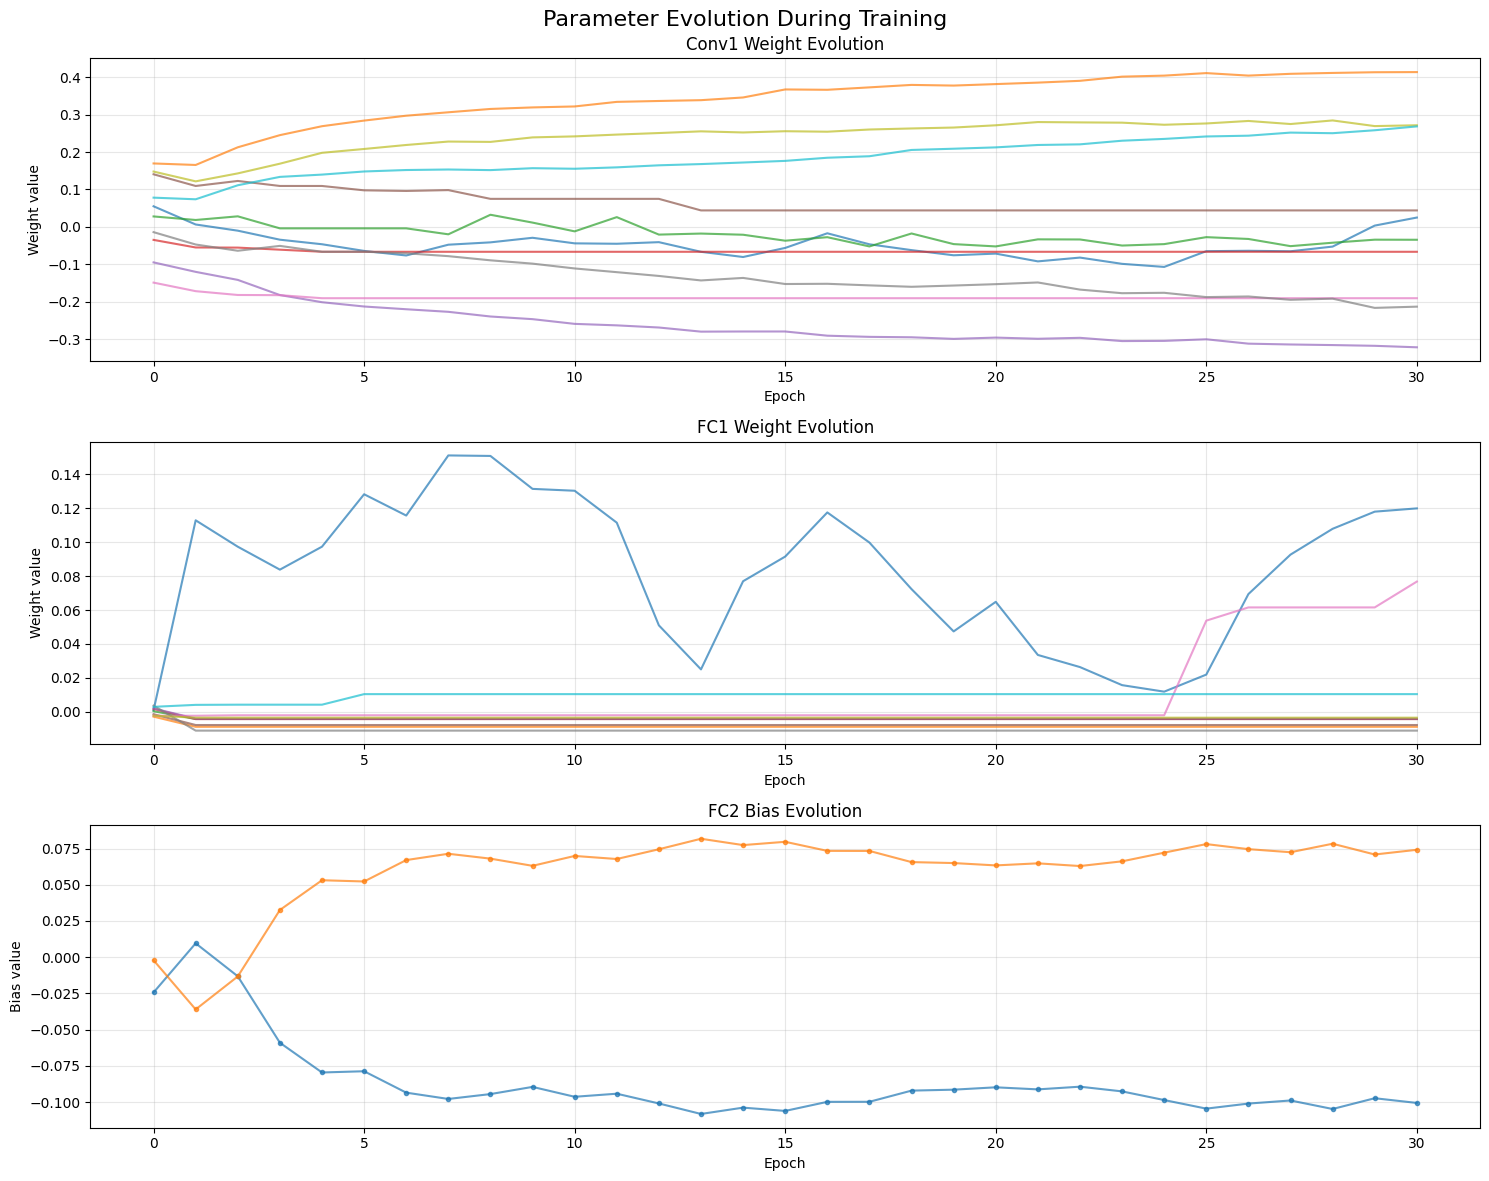

In [43]:
tracker = ParameterTracker(model, num_params_to_track=10)
tracker.history = checkpoint['tracker_history']
tracker.plot_evolution()